# Checking Avilable GPU

In [1]:
!nvidia-smi

Wed Sep 13 23:12:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    36W / 350W |    401MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing requirements

In [2]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

# device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Getting Dataset

In [6]:
from torchvision import transforms, datasets

data_transforms = transforms.Compose([
                    transforms.Resize((32,32)),
                    # transforms.Lambda(lambda image: image.convert('RGB')),
                    # transforms.Grayscale(num_output_channels=3), # comment this if using 3 channel images
                    transforms.ToTensor(),
                    # transforms.Normalize((0.1307,), (0.3081,))
                ])


# test on paper dataset
# train_dataset = datasets.CIFAR10(
#     root='data/',
#     download=True,
#     train=True,
#     transform= data_transforms
# )

# test_dataset = datasets.CIFAR10(
#     root='data/',
#     download=True,
#     train=False,
#     transform= data_transforms
# )

# test on another dataset

train_dataset = datasets.Flowers102(
    root='data/',
    download=True,
    split="train",
    transform= data_transforms
)

test_dataset = datasets.Flowers102(
    root='data/',
    download=True,
    split="test",
    transform= data_transforms
)
# print(train_dataset)
num_classes = len(list(set(train_dataset._labels)))
# num_classes = len(train_dataset.classes)

In [7]:
x,y = train_dataset[100]
x.shape

torch.Size([3, 32, 32])

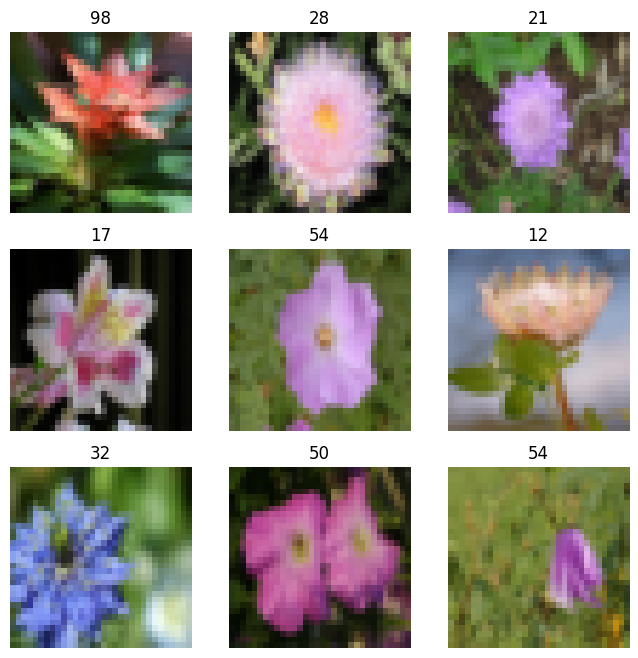

In [8]:
# classes = train_dataset.classes
classes = list(set(train_dataset._labels))
labels_map = {classes[i]:i for i in range(len(classes))}  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    # print(sample_idx)
    img,label = train_dataset[sample_idx.item()]  # getting image and label of selected index
    # sub plot code
    # print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
        # img[1:]
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

# Model Defination

In [7]:
from torchvision.models import vgg16

# model = vgg16() # will be traing form scratch
# model.classifier[6] =  nn.Linear(in_features=4096, out_features=num_classes, bias=True)
# model = model.to(device=device)
#  model arch takken from paper implementation.
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(16384, 128)
        self.fc2 = nn.Linear(128, num_classes) # NOTE: change to number of classes

    def get_features(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
    def stochastic_pred(self, x):
        # add dropouts everywhere
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


model = Net()

In [8]:
summary(
    model=model,
    input_size=(1,3,32,32),
    )

/home/curie/anaconda3/envs/cs/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 102]                  --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─Conv2d: 1-2                            [1, 64, 32, 32]           18,496
├─Dropout: 1-3                           [1, 64, 16, 16]           --
├─Linear: 1-4                            [1, 128]                  2,097,280
├─Dropout: 1-5                           [1, 128]                  --
├─Linear: 1-6                            [1, 102]                  13,158
Total params: 2,129,830
Trainable params: 2,129,830
Non-trainable params: 0
Total mult-adds (M): 21.97
Input size (MB): 0.01
Forward/backward pass size (MB): 0.79
Params size (MB): 8.52
Estimated Total Size (MB): 9.32

# Hyper parms

In [9]:
# parms
EPOCHS=10
LR=0.001
GAMMA=0.1
INIT_SIZE=100
AL_BSIZE=100
# SAMPLE_METHOD="coreset"
SAMPLE_METHOD="random"
OUT_DIR="output"
DATASET_NAME="Flowers102"
MAX_EPISODES=10
BATCH_SIZE=32
TEST_BATCH_SIZE=1000
DEVICE = device

In [10]:
# NOTE: working with index
import random

data_idx = list(range(len(train_dataset)))
random.shuffle(data_idx)

# Creating Init Pool
labeled = data_idx[:INIT_SIZE] # selecting inital samples to get inital pool
unlabeled = data_idx[INIT_SIZE:] # removing the selected samples form the unlabeled set


In [11]:
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam, lr_scheduler
# initial training setup
kwargs = {'num_workers': 0, 'pin_memory': True} if device == 'cuda' else {}
train_loader = DataLoader(Subset(train_dataset,labeled), batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, **kwargs)

# setup the optimizer & Schedular
optimizer = Adam(model.parameters(), lr=LR) 
scheduler = lr_scheduler.StepLR(optimizer, step_size = 1, gamma=GAMMA)
loss_fn = nn.NLLLoss()
accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device=device)

In [12]:
# # training inital model
from engine import train

# train(
#     model=model,
#     test_dataloader=test_loader,
#     train_dataloader=train_loader,
#     epochs=EPOCHS,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     acc_fn=accuracy_fn,
#     device=device,
#     scheduler=scheduler,
#     save_info=f"episode_0"
# )

In [13]:
from tqdm.auto import tqdm
from active_selection import active_sample
import os
import wandb
import config   
# start the active learning loop.

wandb.login(key=config.API_KEY)
print("[LOG]: Login Succesfull.")

if not os.path.exists('./models'):
   os.makedirs('./models')

episode_id = 1
with tqdm(list(range(1,MAX_EPISODES + 1)), unit="episode", leave=False) as tepisode:
    for episode in tepisode:
        wandb.init(
        # set the wandb project where this run will be logged
        project="aml-ass-1",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": LR,
        "sample_method": SAMPLE_METHOD,
        "gamma": GAMMA,
        "init_size": INIT_SIZE,
        "batch_size": BATCH_SIZE,
        "test_batch_size": TEST_BATCH_SIZE,
        "architecture": "VGG16",
        "dataset": DATASET_NAME,
        "epochs": EPOCHS,
        "episode": episode_id
        }
    )
        tepisode.set_description(f"Episode: {episode}")
        labeled,unlabeled = active_sample(
            labeled=labeled,
            unlabeled=unlabeled,
            sample_size=AL_BSIZE,
            dataset=train_dataset,
            method=SAMPLE_METHOD,
            model= model,
            device=DEVICE
        )
        
        
        model = Net() # will be traing form scratch
        # model.classifier[6] =  nn.Linear(in_features=4096, out_features=num_classes, bias=True)
        model = model.to(device=device)
        
        optimizer = Adam(model.parameters(), lr=LR) 
        loss_fn = nn.NLLLoss()
        accuracy_fn = Accuracy(task="multiclass", num_classes=num_classes).to(device=device)
        
        train(
            model=model,
            test_dataloader=test_loader,
            train_dataloader=train_loader,
            epochs=EPOCHS,
            optimizer=optimizer,
            loss_fn=loss_fn,
            acc_fn=accuracy_fn,
            device=device,
            scheduler=scheduler,
            save_info=f"episode_{episode_id}"
        )
        episode_id +=1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: d22cs051. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/curie/.netrc


[LOG]: Login Succesfull.


  0%|          | 0/10 [00:00<?, ?episode/s]

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

/home/curie/anaconda3/envs/cs/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/10 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/13 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/16 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/19 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/22 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/25 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/29 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

  0%|          | 0/32 [00:00<?, ?batch/s]

  0%|          | 0/7 [00:00<?, ?batch/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
